## Load modules

In [1]:
%matplotlib inline
import os
import glob
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import multiprocessing
from functools import partial

import pydicom as dicom
import nibabel as nib

### Set path

In [2]:
# TODO: modify the following paths
train_image_folder = "../input/train-images/image/"
train_label_folder = "../input/train-labels/label/"
test_image_folder = "../input/test-images/image/"

train_list = os.listdir(train_image_folder)

# Ignore this data
if 'hmvsa0loxh3ek2y8rzmcyb6zrrh9mwyp' in train_list:
    train_list.remove('hmvsa0loxh3ek2y8rzmcyb6zrrh9mwyp')
    
print('Train data:', len(train_list))

Train data: 138


In [3]:
def load_dicom_volume(src_dir, suffix='*.dcm'):
    """Load DICOM volume and get meta data.
    """
    encode_name = src_dir.split('/')[-1]
    # Read dicom files from the source directory
    # Sort the dicom slices in their respective order by slice location
    dicom_scans = [dicom.read_file(sp) \
                   for sp in glob.glob(os.path.join(src_dir, suffix))]
    # dicom_scans.sort(key=lambda s: float(s.SliceLocation))
    dicom_scans.sort(key=lambda s: float(s[(0x0020, 0x0032)][2]))

    # Convert to int16, should be possible as values should always be low enough
    # Volume image is in z, y, x order
    volume_image = np.stack([ds.pixel_array \
                             for ds in dicom_scans]).astype(np.int16)
    return encode_name, volume_image

def load_label(label_fpath, transpose=False):
    encode_name = label_fpath[-39: -7]
    label_data = nib.load(label_fpath)
    label_array = label_data.get_fdata()
    if transpose:
        label_array = np.transpose(label_array, axes=(2, 1, 0))
    return encode_name, label_array

## DICOM to npz

In [4]:
train_image_npz_folder = './npz/train_images/'

if not os.path.exists(train_image_npz_folder):
    os.makedirs(train_image_npz_folder)

In [5]:
for encode in tqdm.tqdm(train_list):
    _, volume_image = load_dicom_volume(os.path.join(train_image_folder, encode))
    npz_folder = os.path.join(train_image_npz_folder, encode)
    if not os.path.exists(npz_folder):
        os.mkdir(npz_folder) 
        
    num_slice = volume_image.shape[0]
    for _z in range(0, num_slice):
        npz_path = os.path.join(npz_folder, "%03d.npz"%(_z))
        np.savez_compressed(npz_path, image=volume_image[_z])
        
    del volume_image

100%|██████████| 138/138 [12:11<00:00,  5.87s/it]


In [6]:
!ls './npz/train_images/'

03bx24c1mzl7s9pqakoyt1jqmp7cyzga  j1p9iaj7k74r9d5j0jreadj8wgv7ja3o
081j5f5m21t7nb1yd03uncoofau9cfzu  j8khbaawyee4l62omt3lj1cnm341gkws
0fjeqffgptvghl67enh9768ja0gr1cxa  jgeqimtpbet66qnxrkx46w6re0lxgw3i
174iu1tagmhsuf1gpaep4neeh504kz9l  jptl2g69invzxvhxud8s4c8nbed2z0w1
1cjggtlk17z3yzmbu1sa94vueum4jqw3  juo9o5bqnxhcjcd97sf4jbk8q2ylpu9u
1okl5s5owdr0q8lwpq4kfiqwpdeuj5tn  jx6s7d44mu0gm67eglc22uorx0i3m0pg
1v33cimocil7livtswez02ag7zhrj7bw  jxnt5nkian5ih6rr1qk96bubvr05088t
244esbhzjg4je4dq37wdapz9zf81z41c  l5lnq23o7n2o2hvbxzv9x8sip5qpoasz
2skyephnmr3k2bdux5ud61a8if3j1bqv  lpp3c9hwquq1df0azzi6d9p8kupyap69
2w2suqniwvkbxnfdpi2qayhlyfouhozt  lzb5xxrdsxzuqjhawi1o5zrn56ei7gsw
2wl8od3lbvg4mshmnk7lrk7k3jnxq3sm  mb2eh536dir6krz3fyrdmhwrzk9ddbta
3aakrmc6ptivx0qe4qrxnyjjv88s9afi  mdz5hgdkvhzq6fsdibjdcmffeacrmo6n
3mnrdz2gsy5nc33euleuwylgyr48yj8z  mfms4vpcpzpmtff0f806l0m8llrh56tg
3zmprnfquchu6f51dyf34x34rchn2kkz  mtavwzg2d8jta926np6ae0uf8o7p3h9b
41xlgqbk42c0wqzrwyl43lvgpf9n90qz  n4y1776e8bplu67noj20wkzhztvr

## NIFTI to npz

In [7]:
train_label_npz_folder = './npz/train_labels/'

if not os.path.exists(train_label_npz_folder):
    os.makedirs(train_label_npz_folder)

In [8]:
for encode in tqdm.tqdm(train_list):
    _, label_array = load_label(os.path.join(train_label_folder, encode + '.nii.gz'), transpose=True)
    npz_folder = os.path.join(train_label_npz_folder, encode)
    if not os.path.exists(npz_folder):
        os.mkdir(npz_folder) 
        
    num_slice = label_array.shape[0]
    for _z in range(0, num_slice):
        npz_path = os.path.join(npz_folder, "%03d.npz"%(_z))
        np.savez_compressed(npz_path, label=label_array[_z])
        
    del label_array

100%|██████████| 138/138 [06:28<00:00,  3.10s/it]


## Try to apply UNet 

In [9]:
from keras.models import Model, load_model
from keras import layers as klayers
from keras.optimizers import Adam
from keras import utils as kutils
from keras import backend as K
from keras.callbacks import ModelCheckpoint
import tensorflow as tf

# Make sure keras running on GPU
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

### Data generator

In [10]:
map_image_list = sorted(glob.glob(os.path.join(train_image_npz_folder, '*/*.npz')))
map_label_list = sorted(glob.glob(os.path.join(train_label_npz_folder, '*/*.npz')))

map_df = pd.DataFrame(data={'image': map_image_list, 'label': map_label_list})
map_df.head()

,image,label
0,./npz/train_images/03bx24c1mzl7s9pqakoyt1jqmp7...,./npz/train_labels/03bx24c1mzl7s9pqakoyt1jqmp7...
1,./npz/train_images/03bx24c1mzl7s9pqakoyt1jqmp7...,./npz/train_labels/03bx24c1mzl7s9pqakoyt1jqmp7...
2,./npz/train_images/03bx24c1mzl7s9pqakoyt1jqmp7...,./npz/train_labels/03bx24c1mzl7s9pqakoyt1jqmp7...
3,./npz/train_images/03bx24c1mzl7s9pqakoyt1jqmp7...,./npz/train_labels/03bx24c1mzl7s9pqakoyt1jqmp7...
4,./npz/train_images/03bx24c1mzl7s9pqakoyt1jqmp7...,./npz/train_labels/03bx24c1mzl7s9pqakoyt1jqmp7...


In [11]:
class LungSliceModelGenerator(kutils.Sequence):
    'Generates data for Keras'
    def __init__(self, mapping_df, batch_size, shuffle=True):
        'Initialization'
        self.mapping_df = mapping_df
        self.data_num   = mapping_df.shape[0]
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(self.data_num / self.batch_size))


    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        batch_mapping_df = \
            self.mapping_df.iloc[index*self.batch_size: (index+1)*self.batch_size]

        # Generate data
        X, y = self.__data_generation(batch_mapping_df)
        return X, y


    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle:
            self.mapping_df = self.mapping_df.sample(frac=1).reset_index(drop=True)
            
    def __data_generation(self, batch_mapping_df):
        'Generates data containing batch_size samples' 
        # Initialization
        X = np.zeros((self.batch_size, 512, 512, 1))
        y = np.zeros((self.batch_size, 512, 512, 1))

        # Generate data
        cnt = 0
        for i, row in batch_mapping_df.iterrows():
            X[cnt, :, :, 0] = np.load(row['image'])['image']
            y[cnt, :, :, 0] = np.load(row['label'])['label']
            cnt += 1
        return X, y

In [12]:
batch_size = 16
train_df = map_df.iloc[:-1000]
valid_df = map_df.iloc[-1000:]
train_slice_generator = LungSliceModelGenerator(train_df, batch_size=batch_size)
valid_slice_generator = LungSliceModelGenerator(valid_df, batch_size=batch_size)

## Loss function

In [13]:
def _dice_coefficient(threshold = 0.3):
    def hard_dice_coefficient(y_true, y_pred, smooth=1.0):
        y_true_f = K.flatten(K.cast(y_true > threshold, dtype=float))
        y_pred_f = K.flatten(K.cast(y_pred > threshold, dtype=float))
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return hard_dice_coefficient

def dice_coefficient_loss(y_true, y_pred):
    return 1 - _dice_coefficient()(y_true, y_pred)

## Model architecture

In [14]:
def unet(pretrained_weights=None, input_size=[512, 512, 1], depth=3, init_filter=8, 
         filter_size=3, padding='same', pool_size=[2, 2], strides=[2, 2]):
    
    inputs = klayers.Input(input_size)
    
    current_layer = inputs
    encoding_layers = []
    
    # Encoder path
    for d in range(depth + 1):
        num_filters = init_filter * 2 ** d
        
        conv = klayers.Conv2D(num_filters, filter_size, padding=padding, kernel_initializer='he_normal')(current_layer)
        conv = klayers.BatchNormalization()(conv)
        conv = klayers.Activation('relu')(conv)
        conv = klayers.Conv2D(num_filters * 2, filter_size, padding=padding, kernel_initializer='he_normal')(conv)
        conv = klayers.BatchNormalization()(conv)
        conv = klayers.Activation('relu')(conv)
        encoding_layers.append(conv)
    
        pool = klayers.MaxPooling2D(pool_size=pool_size)(conv)
        
        if d == depth:
            # Bridge
            current_layer = conv
        else:
            current_layer = pool

        
    # Decoder path
    for d in range(depth, 0, -1):
        num_filters = init_filter * 2 ** d
        up = klayers.Deconvolution2D(num_filters * 2, pool_size, strides=strides)(current_layer)

        crop_layer = encoding_layers[d - 1]
        # Calculate two layers shape
        up_shape = np.array(up._keras_shape[1:-1])
        conv_shape = np.array(crop_layer._keras_shape[1:-1])

        # Calculate crop size of left and right
        crop_left = (conv_shape - up_shape) // 2

        crop_right = (conv_shape - up_shape) // 2 + (conv_shape - up_shape) % 2
        crop_sizes = tuple(zip(crop_left, crop_right))

        crop = klayers.Cropping2D(cropping=crop_sizes)(crop_layer)

        # Concatenate
        up = klayers.Concatenate(axis=-1)([crop, up])
        conv = klayers.Conv2D(num_filters, filter_size, padding=padding, kernel_initializer='he_normal')(up)
        conv = klayers.BatchNormalization()(conv)
        conv = klayers.Activation('relu')(conv)
        conv = klayers.Conv2D(num_filters, filter_size, padding=padding, kernel_initializer='he_normal')(conv)
        conv = klayers.BatchNormalization()(conv)
        conv = klayers.Activation('relu')(conv)
        
        current_layer = conv
    
    
    outputs = klayers.Conv2D(1, 1, padding=padding, kernel_initializer='he_normal')(current_layer)
    outputs = klayers.Activation('sigmoid')(outputs)
    model = Model(inputs=inputs, outputs=outputs)

    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

In [15]:
model = unet(depth=3)
model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=[_dice_coefficient(0.3)])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 8)  80          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 512, 512, 8)  32          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 512, 512, 8)  0           batch_normalization_1[0][0]      
_____________________________________

In [16]:
modelcheckpoint = ModelCheckpoint('model-{epoch:03d}.h5', save_best_only=False, period=5)
history = model.fit_generator(train_slice_generator, validation_data=valid_slice_generator, epochs=15, callbacks=[modelcheckpoint], verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/15
942/942 [==============================] - 407s 432ms/step - loss: 0.1530 - hard_dice_coefficient: 8.3140e-04 - val_loss: 0.0861 - val_hard_dice_coefficient: 0.0028
Epoch 2/15
942/942 [==============================] - 399s 423ms/step - loss: 0.0607 - hard_dice_coefficient: 0.0176 - val_loss: 0.0425 - val_hard_dice_coefficient: 0.1701
Epoch 3/15
942/942 [==============================] - 401s 425ms/step - loss: 0.0315 - hard_dice_coefficient: 0.0922 - val_loss: 0.0232 - val_hard_dice_coefficient: 0.1942
Epoch 4/15
942/942 [==============================] - 401s 426ms/step - loss: 0.0182 - hard_dice_coefficient: 0.1039 - val_loss: 0.0135 - val_hard_dice_coefficient: 0.1304
Epoch 5/15
942/942 [==============================] - 401s 426ms/step - loss: 0.0114 - hard_dice_coefficient: 0.0975 - val_loss: 0.0091 - val_hard_dice_coefficient: 0.2266
Epoch 6/15
446/942 [=============>................] - ETA: 3:24 - loss: 0.0085 - hard_di

In [17]:
# list all data in history
print(history.history.keys())

dict_keys(['val_loss', 'val_hard_dice_coefficient', 'loss', 'hard_dice_coefficient'])


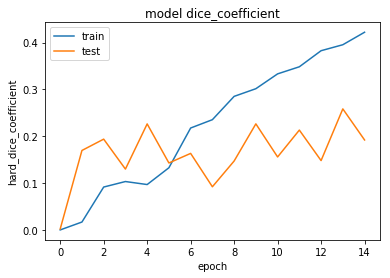

In [18]:
# summarize history for hard_dice_coefficient
plt.plot(history.history['hard_dice_coefficient'])
plt.plot(history.history['val_hard_dice_coefficient'])
plt.title('model dice_coefficient')
plt.ylabel('hard_dice_coefficient')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

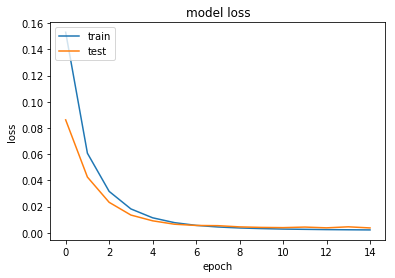

In [19]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [20]:
#del model

In [21]:
check_model = load_model('model-015.h5', custom_objects={'hard_dice_coefficient': _dice_coefficient(0.3)})

## Predict test images

In [22]:
def retrieve_pred_str(src_dir, model, threshold=0.4):
    encode_name = src_dir.split('/')[-1]
    
    _, test_volume = load_dicom_volume(src_dir, suffix='*.dcm')
    
    pred_label = model.predict(np.expand_dims(test_volume, axis=-1))
    pred_label = np.transpose(pred_label[:, :, :, 0], axes=(2, 1, 0))
    
    pred_label = (pred_label > threshold).astype(np.int)

    label_flatten = pred_label.flatten()

    label_flatten_idx = np.where(label_flatten == 1)[0]

    label_str = ''
    
    if label_flatten_idx.size > 0:
        prev_idx = label_flatten_idx[0]
        idx_start = label_flatten_idx[0]
        cnt = 1
        for _idx in label_flatten_idx[1:]:
            if _idx == prev_idx+1:
                cnt += 1
            else:
                label_str += str(idx_start) + ' ' + str(cnt) + ' '

                cnt = 1
                idx_start = _idx
            prev_idx = _idx

        label_str = label_str.rstrip(' ')
    return (encode_name, label_str)

In [23]:
sample_submission = np.genfromtxt('../input/sample_submission.csv', 
                                  delimiter=',', 
                                  dtype='str',
                                  skip_header = 1)

In [24]:
test_encode_list = sample_submission[:, 0]

In [25]:
pred_pair_list = []

for encode_name in tqdm.tqdm(test_encode_list, total=len(test_encode_list)):
    (encode, label_str) = retrieve_pred_str(os.path.join(test_image_folder, encode_name), check_model, threshold=0.3)
    pred_pair_list.append((encode, label_str))

100%|██████████| 139/139 [09:39<00:00,  4.46s/it]


In [26]:
solution_path = './sample-code_pred.csv'
with open(solution_path, 'w') as f:
    f.write('encode,pixel_value\n')
    for _pair in pred_pair_list:
        encode = _pair[0]
        label_str = _pair[1]
        f.write(encode + ',' + label_str + '\n')

# Show Predicted Image

In [27]:
# Read dicom files from the source directory
# Sort the dicom slices in their respective order by slice location
dicom_scans = [dicom.read_file(os.path.join(os.path.join(test_image_folder, 'jdndkse8voi5t59sr8y1z9nuh1a4k09s'), '000051.dcm')),
              dicom.read_file(os.path.join(os.path.join(test_image_folder, 'ob3o558sc26crrdtv38b2z7fjl8xpqda'), '000058.dcm')),
              dicom.read_file(os.path.join(os.path.join(test_image_folder, 'k9plcilsqtwwwuu9oj2logl8ph5cmmmx'), '000057.dcm'))]
# dicom_scans.sort(key=lambda s: float(s.SliceLocation))
dicom_scans.sort(key=lambda s: float(s[(0x0020, 0x0032)][2]))

# Convert to int16, should be possible as values should always be low enough
# Volume image is in z, y, x order
volume_image = np.stack([ds.pixel_array \
                         for ds in dicom_scans]).astype(np.int16)
test_volume_image = np.expand_dims(volume_image, -1)

In [28]:
early_model = load_model('model-005.h5', custom_objects={'hard_dice_coefficient': _dice_coefficient(0.3)})
middle_model = load_model('model-010.h5', custom_objects={'hard_dice_coefficient': _dice_coefficient(0.3)})

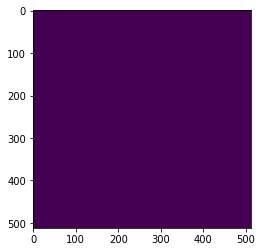

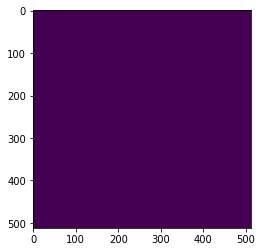

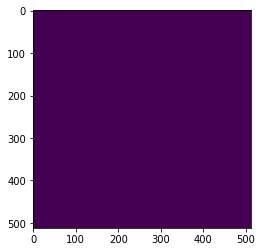

In [29]:
test_label = early_model.predict(test_volume_image)
pred_label = (test_label > 0.3).astype(np.int)
label_flatten = np.squeeze(pred_label, -1)

for row in label_flatten:
    plt.imshow(row)
    plt.show()

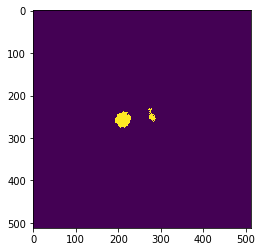

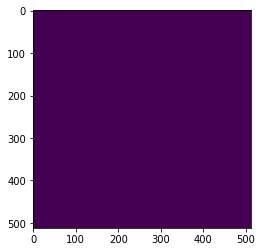

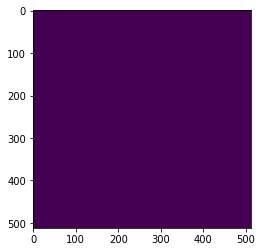

In [30]:
test_label = middle_model.predict(test_volume_image)
pred_label = (test_label > 0.3).astype(np.int)
label_flatten = np.squeeze(pred_label, -1)

for row in label_flatten:
    plt.imshow(row)
    plt.show()

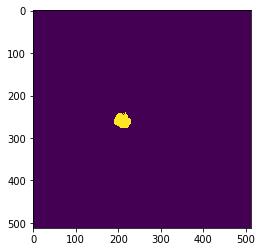

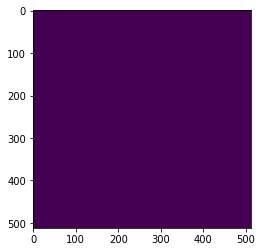

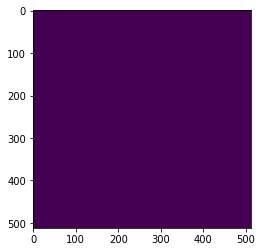

In [31]:
test_label = check_model.predict(test_volume_image)
pred_label = (test_label > 0.3).astype(np.int)
label_flatten = np.squeeze(pred_label, -1)

for row in label_flatten:
    plt.imshow(row)
    plt.show()

## Remove all npz files

In [32]:
!rm -r ./npz